# Precio de inmuebles por radio censal

In [8]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import dataset
import sys
import psycopg2
from simpledbf import Dbf5
from scripts.land_prices import get_data, remove_scarce_data
from scripts.land_prices import intersect_data_with_shps, read_dataset
from scripts.path_finders import get_division_path, get_data_dir, get_indicators_path
from scripts.cartodb_layers import merge_shapefiles

PyTables is not installed. No support for HDF output.


## 1. Mergear los shapefiles desde el 2001 al 2014

Se juntan los shapefiles de cada año en uno solo. Se eligen los campos a mantener para reducir el tamaño.

In [2]:
prices_dir = "data"
output_path = os.path.join("deptos", "deptos")
replacements = {
    "BARRIO": ["BARRIOS"],
    "LON": ["X"],
    "LAT": ["Y"],
    "LON": ["LONGITUD"],
    "LAT": ["LATITUD"],
    "U_S_M2": ["US_M2"]
}

In [86]:
w = merge_shapefiles(prices_dir, output_path, group_fields=replacements, 
                     fields_to_keep=["U_S_M2", "DOLARES", "M2", "YEAR"])

Merging 1 2002            deptos_2002
Merging 1 2003            deptos_2003
Merging 1 2001            deptos_2001
Merging 1 2006            deptos_2006
Merging 1 2007            deptos_2007
Merging 1 2004            deptos_2004
Merging 1 2005            deptos_2005
Merging 1 2014            deptos_2014
Merging 1 2008            deptos_2008
Merging 1 2009            deptos_2009
Merging 1 2011            deptos_2011
Merging 1 2010            deptos_2010
Merging 1 2013            deptos_2013
Merging 1 2012            deptos_2012


In [87]:
df = Dbf5(output_path + ".dbf").to_dataframe()

In [89]:
df.orig_sf.unique()

array([u'2002', u'2003', u'2001', u'2006', u'2007', u'2004', u'2005',
       u'2014', u'2008', u'2009', u'2011', u'2010', u'2013', u'2012'], dtype=object)

## 2. Asignar divisiones de la CABA a cada inmueble

El shapefile mergeado se debe cargar a una base de datos PostgreSQL. Para esto se puede usar una herramienta externa como *pgShapeLoader*.

* **Asignar la manzana que contiene al inmueble** 
    * `ALTER TABLE deptos ADD id_manzana text;`
    * `UPDATE deptos SET id_manzana = m.ID FROM manzanas_censo_2010 m WHERE ST_Contains(m.geom, deptos.geom);`
    * `UPDATE deptos SET id_manzana = m.ID FROM manzanas_censo_2010 m WHERE deptos.id_manzana is NULL AND ST_DWithin(m.geom, deptos.geom, 25);`
* **Asignar la parcela que contiene al inmueble** 
    * `ALTER TABLE deptos ADD SMP text;`
    * `UPDATE deptos SET SMP = p.SMP FROM mo_parcelascatastro_15072014 p WHERE ST_Contains(p.geom, deptos.geom);`
    * `UPDATE deptos SET SMP = p.SMP FROM mo_parcelascatastro_15072014 p WHERE deptos.SMP is NULL AND ST_DWithin(p.geom, deptos.geom, 25);`
* **Asignar el radio que contiene al inmueble** 
    * `ALTER TABLE deptos ADD CO_FRAC_RA text;`
    * `UPDATE deptos SET CO_FRAC_RA = r.CO_FRAC_RA FROM radios_censo_2010 r WHERE ST_Contains(r.geom, deptos.geom);`
* **Asignar la fracción que contiene al inmueble** 
    * `ALTER TABLE deptos ADD CO_FRACC text;`
    * `UPDATE deptos SET CO_FRACC = f.CO_FRACC FROM fracciones_censo_2010 f WHERE ST_Contains(f.geom, deptos.geom);`
* **Asignar la barrio que contiene al inmueble** 
    * `ALTER TABLE deptos ADD BARRIO text;`
    * `UPDATE deptos SET BARRIO = b.BARRIOS FROM barrios_censo_2010 b WHERE ST_Contains(b.geom, deptos.geom);`
* **Asignar la comuna que contiene al inmueble** 
    * `ALTER TABLE deptos ADD COMUNA text;`
    * `UPDATE deptos SET COMUNA = c.COMUNAS FROM comunas_censo_2010 c WHERE ST_Contains(c.geom, deptos.geom);`
* **Transformar tabla postgis en shp**
    * `pgsql2shp -f deptos_con_divs/deptos_con_divs -h localhost -p 5432 abenassi "SELECT * FROM deptos;"`

## 3. Mergear divisiones de la CABA en un sólo shapefile

In [72]:
paths = {
    "RADIO": get_division_path("radios_censo_2010"),
    "BARRIO": get_division_path("barrios_censo_2010"),
    "DPTO": get_division_path("comunas_caba_censo_2010"),
    "FRAC": get_division_path("fracciones_caba_censo_2010")
}
group_fields_by_sf = {
    "RADIO": {"co_frac_ra": "id_div"},
    "FRAC": {"co_fracc": "id_div"},
    "BARRIO": {"barrios": "id_div"},
    "DPTO": {"comunas": "id_div"}
}
divs_path = os.path.join("divisiones", "divisiones")
fields_to_keep = ["orig_sf", "ID_DIV"]

In [22]:
w = merge_shapefiles(paths, divs_path, group_fields_by_sf=group_fields_by_sf,
                    fields_to_keep=fields_to_keep)

Merging 5 FRAC            fracciones_censo_2010
Merging 5 DPTO            comunas_censo_2010
Merging 5 RADIO           radios_censo_2010
Merging 5 BARRIO          barrios_censo_2010


Contamos la cantidad de divisiones de cada categoría, para controlar que el shapefile se mergeó correctamente.

In [105]:
df = Dbf5(divs_path + ".dbf").to_dataframe()

In [108]:
for area_level in paths:
    print area_level, len(df[df.ORIG_SF == area_level])

FRAC 351
DPTO 15
RADIO 3554
BARRIO 48


## 4. Calcular los promedios por división de la CABA

In [99]:
def gen_query_area_level_average(area_level, year):

    area_level_id_fields = {
        "RADIO": "co_frac_ra",
        "FRAC": "co_fracc",
        "BARRIO": "barrio",
        "DPTO": "comuna"
    }
    
    query = """
    WITH average AS
        (SELECT {0}, 
         CASE 
             WHEN sum(deptos_con_divs.m2) > 0 THEN sum(deptos_con_divs.dolares) / sum(deptos_con_divs.m2)
             ELSE 0
         END AS usdm2
         FROM deptos_con_divs WHERE orig_sf = '{2}'
         GROUP BY {0})

    UPDATE divisiones SET {3} = average.usdm2
    FROM average
    WHERE divisiones.orig_sf = '{1}' AND divisiones.id_div = average.{0}
    """.format(area_level_id_fields[area_level], area_level, year, "usdm2_" + unicode(year))
    
    return query

In [100]:
def gen_query_create_column(year, table="divisiones"):
    return "ALTER TABLE {} ADD {} decimal;".format(table, "usdm2_" + unicode(year))

In [101]:
def calc_area_levels_average(area_levels, years):
    db = dataset.connect('postgresql://localhost:5432')

    for year in years:
        print "Calculating averages for", year,
        sys.stdout.flush()
        
        if "usdm2_" + unicode(year) not in db.get_table("divisiones").columns:
            query_column = gen_query_create_column(year)
            db.begin()
            db.query(query_column)
            db.commit()

        
        for area_level in area_levels:
            print area_level,
            query_calc_average = gen_query_area_level_average(area_level, year)
            db.begin()
            db.query(query_calc_average)
            db.commit()
        
        print ""

In [102]:
years = range(2001, 2015)
area_levels = ["DPTO", "BARRIO",  "FRAC", "RADIO"]

In [103]:
calc_area_levels_average(area_levels, years)

Calculating averages for 2001 DPTO BARRIO FRAC RADIO 
Calculating averages for 2002 DPTO BARRIO FRAC RADIO 
Calculating averages for 2003 DPTO BARRIO FRAC RADIO 
Calculating averages for 2004 DPTO BARRIO FRAC RADIO 
Calculating averages for 2005 DPTO BARRIO FRAC RADIO 
Calculating averages for 2006 DPTO BARRIO FRAC RADIO 
Calculating averages for 2007 DPTO BARRIO FRAC RADIO 
Calculating averages for 2008 DPTO BARRIO FRAC RADIO 
Calculating averages for 2009 DPTO BARRIO FRAC RADIO 
Calculating averages for 2010 DPTO BARRIO FRAC RADIO 
Calculating averages for 2011 DPTO BARRIO FRAC RADIO 
Calculating averages for 2012 DPTO BARRIO FRAC RADIO 
Calculating averages for 2013 DPTO BARRIO FRAC RADIO 
Calculating averages for 2014 DPTO BARRIO FRAC RADIO 


Controlamos alguna división (comunas) para ver que los valores de USD por M2 fueron calculados.

In [104]:
db = dataset.connect('postgresql://localhost:5432')
df = pd.read_sql_query("SELECT * FROM divisiones WHERE orig_sf = 'DPTO'", db.engine)
df

gid orig_sf id_div                                               geom  \
0   352    DPTO      1  010600000002000000010300000001000000B7080000C3...   
1   353    DPTO      2  01060000000100000001030000000100000020060000A4...   
2   364    DPTO     13  0106000000010000000103000000010000009509000050...   
3   365    DPTO     14  01060000000100000001030000000100000025080000FA...   
4   355    DPTO      4  0106000000010000000103000000010000003C1C00004A...   
5   357    DPTO      6  010600000001000000010300000001000000970000008C...   
6   359    DPTO      8  010600000001000000010300000001000000AF0100000B...   
7   360    DPTO      9  010600000001000000010300000001000000CE01000071...   
8   356    DPTO      5  010600000001000000010300000001000000E6000000CC...   
9   358    DPTO      7  0106000000010000000103000000010000004C01000034...   
10  366    DPTO     15  010600000001000000010300000001000000270100007C...   
11  362    DPTO     11  0106000000010000000103000000010000002D01000061...   
12  363    DPTO     12  010600000001000000010300000001000000CA00000057...   
13  361    DPTO     10  0106000000010000000103000000010000006D010000B0...   
14  354    DPTO      3  010600000001000000010300000001000000B000000051...   

     usdm2_2001  usdm2_2002  usdm2_2003   usdm2_2004   usdm2_2005  \
0    853.946166  447.166416  538.895486   795.936389  1039.846485   
1   1045.544495  648.638699  800.019776  1090.981854  1162.687407   
2   1016.537881  599.834313  708.369110   974.127022  1034.019409   
3   1063.085873  625.141100  775.257528  1138.558293  1208.335494   
4    678.171238  360.551937  389.066760   557.306863   631.977996   
5    883.199706  493.263002  574.652792   822.574328   876.463269   
6    328.304598  164.677892  291.819721   343.924608   474.971098   
7    635.444418  276.522073  363.445737   537.642839   596.493654   
8    806.084323  438.900795  492.178718   728.880502   773.746893   
9    786.736922  428.298065  469.710027   699.079287   732.212460   
10   782.391236  404.775751  494.379464   728.395925   786.030201   
11   760.015942  375.927956  468.351085   705.937622   754.647467   
12   814.093680  456.815786  549.747053   807.178728   857.178315   
13   697.785948  337.144143  409.005169   612.299205   671.013227   
14   762.632001  378.479102  458.581463   640.404500   721.981614   

     usdm2_2006   usdm2_2007   usdm2_2008   usdm2_2009   usdm2_2010  \
0   1252.667961  1518.823761  1830.228625  1925.980076  1971.497537   
1   1477.822084  1701.800914  2296.118814  2175.527306  2197.907589   
2   1250.741539  1462.520728  2749.422410  1873.256534  2048.203101   
3   1663.470044  1722.082642  2561.059738  2208.065515  2413.943267   
4    825.532747   914.185631  1843.402634  1287.728633  1316.174375   
5   1047.009723  1168.336325  3269.591546  1537.761649  1653.765133   
6    653.082192   685.888078   802.941176   994.218750   939.450145   
7    793.544327   854.498795  1006.303183  1102.129957  1083.022670   
8   1031.454910  1128.752290  1824.983713  1427.026030  1532.675214   
9    896.923454   985.527983  1166.302831  1296.550051  1349.839985   
10   989.025237  1094.734431  1906.563653  1444.747448  1543.664717   
11   969.585923  1051.468571  1261.763790  1448.319948  1437.604490   
12  1083.120253  1168.161131  1938.606342  1560.221333  1533.849068   
13   863.618743   937.583663  1054.359304  1152.451924  1215.760194   
14   888.002540   990.091291  1216.743084  1250.993728  1362.361298   

     usdm2_2011   usdm2_2012   usdm2_2013   usdm2_2014  
0   2616.188885  2505.252011  2228.816227  2745.506788  
1   2726.131170  2624.248091  2524.408878  2693.251721  
2   2383.507266  2599.043860  2444.822097  2654.417989  
3   2916.218154  3094.487841  2830.225507  3097.020112  
4   1497.420524  1912.561362  1691.590059  1724.073403  
5   1950.627192  1967.195026  2066.391301  2266.326888  
6   1105.671365  1743.408983  1225.419742  1235.053038  
7   1446.994095  1690.747133  1604.510404  1687.931090  
8   1824.939723 

In [88]:
# método útil para borrar las columnas de precios por m2 si es necesario
def drop_cols_starting_with(db, start):
    for col in db.get_table("divisiones").columns:
        if col.startswith(start):
            db.get_table("divisiones").drop_column(col)
            print col, "dropped"

In [93]:
drop_cols_starting_with(db, "usd")

usd_m2_2001 dropped
usd_m2_2002 dropped
usd_m2_2003 dropped
usd_m2_2004 dropped
usd_m2_2005 dropped
usd_m2_2006 dropped
usd_m2_2007 dropped
usd_m2_2008 dropped
usd_m2_2009 dropped
usd_m2_2010 dropped
usd_m2_2011 dropped
usd_m2_2012 dropped
usd_m2_2013 dropped
usd_m2_2014 dropped


In [13]:
replacements = {"MONTSERRAT": "MONSERRAT", 
                "NUÑEZ".decode("utf-8"): "NUNEZ",
                "PARQUE AVELLANEDA": "PARQUE AVELLANED", 
                "VILLA GRAL. MITRE": ["VILLA GRAL MITRE", "VILLA GRAL. MITR"]}

In [14]:
df_completo = get_data(years=range(2001, 2015), replacements=replacements, recalculate=False)
df_completo.head()

AMBIENTES  ANTIGUEDAD BANOS    BARRIO BAULERA  BA¥OS  \
0       NaN  A ESTRENAR     2   PALERMO     NaN    NaN   
1       NaN         NaN     2   PALERMO     NaN    NaN   
2       NaN         NaN     2   PALERMO     NaN    NaN   
3       NaN         NaN     2  BELGRANO     NaN    NaN   
4       NaN         NaN     0  BELGRANO     NaN    NaN   

                      CALLE CALLES COCHERA COMUNA  DOLARES LAVADERO   M2  \
0  11 DE SEPTIEMBRE DE 1888    NaN      SI     14   173000      NaN  105   
1  11 DE SEPTIEMBRE DE 1888    NaN      SI     14   169000      NaN  180   
2  11 DE SEPTIEMBRE DE 1888    NaN      SI     14   185000      NaN  165   
3  11 DE SEPTIEMBRE DE 1888    NaN      SI     13   198000      NaN  202   
4  11 DE SEPTIEMBRE DE 1888    NaN     NaN     13    50000      NaN   63   

   NUMERO ORIENT         TERRAZA  U_S_M2  YEAR  
0     882    NaN  BALCON TERRAZA  1647.6  2001  
1    1050    NaN           PATIO   938.9  2001  
2    1144    NaN          BALCON  1121.2  2001  
3    1846    NaN             NaN   980.2  2001  
4    2130    NaN           PATIO   793.7  2001

El año 2014 es el que más cantidad de datos tiene.

In [70]:
def check_null_values(df, indic, return_nulls=False):
    nulls = df[pd.isnull(df[indic])][indic]
    print "{}/{} ({:.2%}) NaNs in {}".format(len(nulls), len(df), len(nulls)/float(len(df)), indic)

    if return_nulls:
        return nulls

In [74]:
for field in df_completo.columns:
    try:
        print check_null_values(df_completo, field.decode("latin-1"))
    except Exception as inst:
        print "\n", inst, field, "\n"

47525/141938 (33.48%) NaNs in AMBIENTES
None
45884/141938 (32.33%) NaNs in ANTIGUEDAD
None
64209/141938 (45.24%) NaNs in BANOS
None
0/141938 (0.00%) NaNs in BARRIO
None
130134/141938 (91.68%) NaNs in BAULERA
None

'ascii' codec can't encode character u'\xa5' in position 2: ordinal not in range(128) BA¥OS 

7524/141938 (5.30%) NaNs in CALLE
None
134414/141938 (94.70%) NaNs in CALLES
None
119423/141938 (84.14%) NaNs in COCHERA
None
0/141938 (0.00%) NaNs in COMUNA
None
0/141938 (0.00%) NaNs in DOLARES
None
108870/141938 (76.70%) NaNs in LAVADERO
None
0/141938 (0.00%) NaNs in M2
None
0/141938 (0.00%) NaNs in NUMERO
None
73933/141938 (52.09%) NaNs in ORIENT
None
85344/141938 (60.13%) NaNs in TERRAZA
None
0/141938 (0.00%) NaNs in U_S_M2
None
0/141938 (0.00%) NaNs in YEAR
None


In [4]:
df_completo.groupby("YEAR").count()

BARRIO  CALLE  COMUNA  DOLARES  FECHA   LAT   LON    M2  NUMERO  U_S_M2  \
YEAR                                                                            
2001    1342   1342    1342     1342   1342  1342  1342  1342    1342    1342   
2002     368    368     368      368    368   368   368   368     368     368   
2003     569    569     569      569    558   569   569   569     569     569   
2004    1211   1213    1212     1213   1213  1213  1213  1213    1213    1213   
2005    1036   1036    1036     1036   1036  1036  1036  1036    1036    1036   
2006    1241   1241    1241     1241   1241  1241  1241  1241    1241    1241   
2007    1707   1707    1707     1707   1707  1707  1707  1707    1707    1707   
2008     889    889     889      889    889   889   889   889     889     889   
2009    1455   1455    1455     1455    960  1455  1455  1455    1455    1455   
2010     878    878     878      878    878   878   878   878     878     878   
2011    1163   1163    1163     1163   1163  1163  1163  1163    1163    1163   
2013    1163   1163    1163     1163   1163  1163  1163  1163    1163    1163   
2014    1861   1861    1861     1861   1312  1861  1861  1861    1861    1861   

      CO_FRACC  CO_FRAC_RA  
YEAR                        
2001      1342        1342  
2002       368         368  
2003       569         569  
2004      1211        1211  
2005      1036        1036  
2006      1240        1240  
2007      1707        1707  
2008       889         889  
2009      1455        1455  
2010       878         878  
2011      1163        1163  
2013      1162        1162  
2014      1861        1861

No se utilizarán datos anteriores a 2006.

In [5]:
df = df_completo[df_completo["YEAR"] > 2005]

Se calculan los precios promedio de los terrenos para distintos niveles de agregación.

In [6]:
def calc_average_usd_m2(df, pivot_unit=None, date_unit="YEAR"):
    if pivot_unit:
        value = pd.pivot_table(df, values='DOLARES', index=[pivot_unit], columns=[date_unit], aggfunc=np.sum)
        m2 = pd.pivot_table(df, values='M2', index=[pivot_unit], columns=[date_unit], aggfunc=np.sum)
    else:
        value = pd.pivot_table(df, values='DOLARES', columns=[date_unit], aggfunc=np.sum)
        m2 = pd.pivot_table(df, values='M2', columns=[date_unit], aggfunc=np.sum)
    return value / m2

In [7]:
comunas = calc_average_usd_m2(df, "COMUNA")
barrios = calc_average_usd_m2(df, "BARRIO")
fracciones = calc_average_usd_m2(df, "CO_FRACC")
caba = calc_average_usd_m2(df)

Eliminamos los promedios realizados con pocos datos. El número indica el mínimo de datos exigido para calcular cada promedio.

In [8]:
remove_scarce_data(comunas, df, "COMUNA", 10)
remove_scarce_data(barrios, df, "BARRIO", 5)
remove_scarce_data(fracciones, df, "CO_FRACC", 3)

COMUNA start with  120 values
COMUNA end with 118 values 

BARRIO start with  373 values
BARRIO end with 346 values 

CO_FRACC start with  2204 values
CO_FRACC end with 1434 values 



Cantidad de unidades ofertadas por precio del m2.

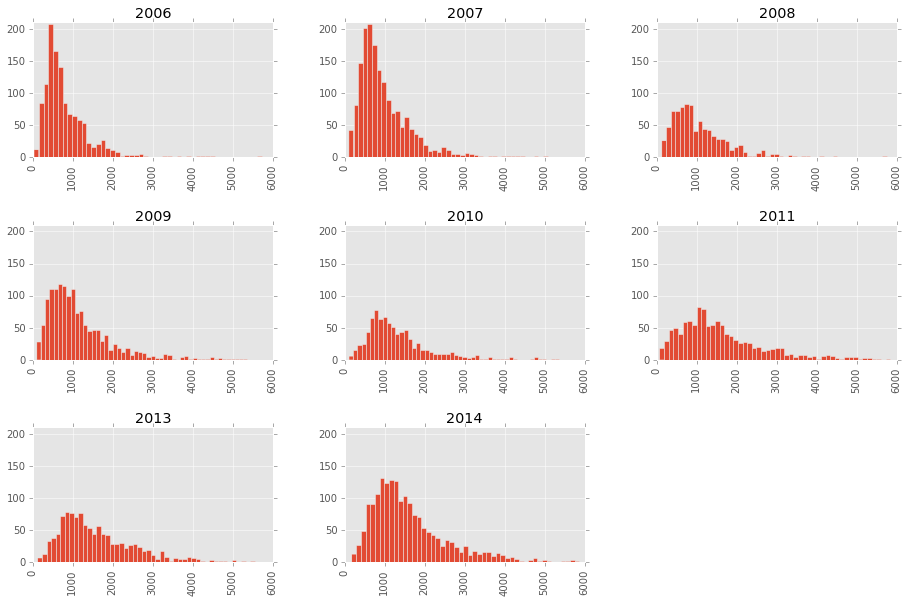

In [9]:
hists = df["U_S_M2"][df["U_S_M2"] < 6000].hist(by=df["YEAR"], bins=50, figsize=(15, 10))
hists = [hist.set_ylim((0, 210)) for row in hists for hist in row]

Precio promedio en la caba del m2 de terreno ofertado.

In [10]:
caba

YEAR
2006     968.110544
2007     976.008934
2008    1090.986450
2009     963.594884
2010    1239.332564
2011    1303.560424
2013    1642.565605
2014    1583.043292
dtype: float64

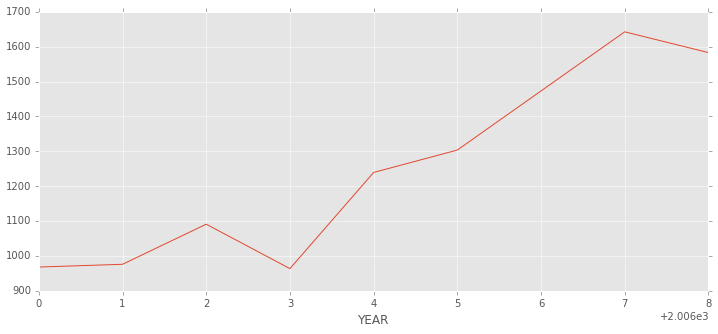

In [11]:
caba.plot(kind="line", figsize=(12, 5))

Testeamos la posibilidad de actualizar los precios por índices a partir del promedio de barrios o comunas, en aquellos casos donde la pérdida de variabilidad entre fracciones dentro del mismo barrio o comuna no parezca demasiado grave.

In [12]:
var_comuna = comunas.transpose().pct_change()
var_barrio = barrios.transpose().pct_change()
var_fracc = fracciones.transpose().pct_change()
var_barrio

BARRIO  AGRONOMIA   ALMAGRO  BALVANERA  BARRACAS  BELGRANO      BOCA  \
YEAR                                                                   
2006          NaN       NaN        NaN       NaN       NaN       NaN   
2007     0.397675  0.083704   0.117623  0.511214  0.166136 -0.108624   
2008     0.267670  0.165592   0.660736  1.577543 -0.044664  0.634175   
2009    -0.344707 -0.155409  -0.439074 -0.474834 -0.132134  0.180430   
2010     0.333620  0.557764   0.781586  0.019018  0.567729  0.023731   
2011    -0.006760  0.448182  -0.068476 -0.005512 -0.362477 -0.232949   
2013    -0.002789 -0.138715   0.592999  0.590933  0.632586  1.221061   
2014    -0.027166 -0.279303  -0.016105  0.132701  0.380122 -0.108693   

BARRIO     BOEDO  CABALLITO  CHACARITA   COGHLAN      ...        \
YEAR                                                  ...         
2006         NaN        NaN        NaN       NaN      ...         
2007    0.184553   0.422800   0.250802 -0.088308      ...         
2008   -0.141599  -0.041607   0.297358  0.215336      ...         
2009   -0.284028   0.021106  -0.250730 -0.099466      ...         
2010    0.748596   0.241701   0.160324  0.027023      ...         
2011   -0.086557   0.318964   0.336426 -0.046498      ...         
2013    0.379511  -0.135366   0.205028  0.191009      ...         
2014    0.031894  -0.045239  -0.318563  0.613298      ...         

BARRIO  VILLA GRAL. MITRE  VILLA LUGANO  VILLA LURO  VILLA ORTUZAR  \
YEAR                                                                 
2006                  NaN           NaN         NaN            NaN   
2007            -0.078325      1.645802    0.032167      -0.015318   
2008             1.056184      0.381845    1.244619       0.175026   
2009            -0.490249      0.072583   -0.422538      -0.233311   
2010             0.537032           NaN    0.490439       1.390584   
2011            -0.341811      0.187735    0.115649      -0.251727   
2013             1.242999           NaN    0.001048      -0.060519   
2014            -0.146527      0.585979    0.191075       0.425658   

BARRIO  VILLA PUEYRREDON  VILLA REAL  VILLA RIACHUELO  VILLA SANTA RITA  \
YEAR                                                                      
2006                 NaN         NaN              NaN               NaN   
2007           -0.033142   -0.051134         0.478956         -0.130968   
2008            0.321132         NaN              NaN         -0.084012   
2009           -0.122063         NaN              NaN          0.593822   
2010            0.351387         NaN              NaN          0.093649   
2011            0.422208    3.919973              NaN          0.382433   
2013           -0.151541   -0.627639         0.172021         -0.018786   
2014            0.095066   -0.252578              NaN          0.114527   

BARRIO  VILLA SOLDATI  VILLA URQUIZA  
YEAR                                  
2006              NaN            NaN  
2007              NaN       0.044493  
2008              NaN       0.056554  
2009              NaN      -0.042757  
2010              NaN      -0.049068  
2011              NaN       0.845459  
2013              NaN      -0.203511  
2014              NaN       0.048805  

[8 rows x 48 columns]

Creamos un data frame con las variaciones por fracción censal y período, para testear modelos que predigan estas variaciones con el promedio barrial o comunal.

In [13]:
df_vars = pd.DataFrame(columns=["CO_FRACC", "periodo", "var_fracc", 
                                "COMUNA", "var_comuna", "BARRIO", "var_barrio"]).set_index(["CO_FRACC", "periodo"])
df_vars

Empty DataFrame
Columns: [var_fracc, COMUNA, var_comuna, BARRIO, var_barrio]
Index: []

In [14]:
def populate_with_vars(df_vars, var_fracc, var_comuna, var_barrio, df_divs):
    for row in var_fracc.iterrows():
        period = row[0]
        for fracc in var_fracc.columns:
            value = row[1][fracc]
            
            if pd.notnull(value):
                comuna = df_divs[df_divs["CO_FRACC"] == fracc]["COMUNA"].iloc[0]
                barrio = df_divs[df_divs["CO_FRACC"] == fracc]["BARRIO"].iloc[0]
                df_vars.ix[(fracc, period), :] = [value, comuna, var_comuna[comuna][period], 
                                                  barrio, var_barrio[barrio][period]]
        

No utilizamos las variaciones 2011-2013 porque corresponden a 2 años juntos.

In [15]:
populate_with_vars(df_vars, var_fracc[~var_fracc.index.isin([2013])], var_comuna, var_barrio, df)

/Users/abenassi/anaconda/envs/tod/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


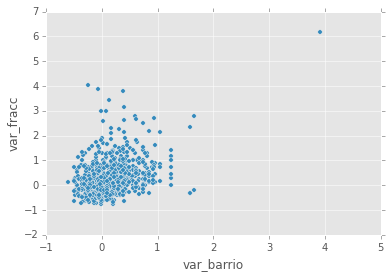

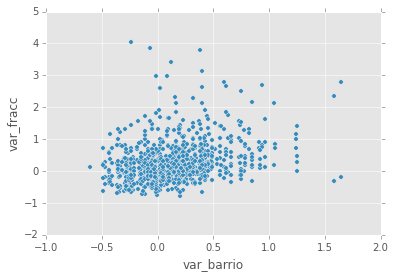

In [16]:
df_vars.plot(kind="scatter", y="var_fracc", x="var_barrio")
df_vars[df_vars["var_barrio"] < 2].plot(kind="scatter", y="var_fracc", x="var_barrio")

No parece haber mucha relación, pero miremos el resultado de una regresión lineal.

In [17]:
from sklearn.linear_model import LinearRegression

Eliminamos los datos con missings.

In [18]:
print len(df_vars), "with nans"
df_vars_clean = df_vars.dropna()
print len(df_vars_clean), "without nans"

983 with nans
974 without nans


Eliminamos los barrios cuyos promedios fueron calculados a partir de muy pocos datos.

In [19]:
def count_fracc_por_barrio(barrio):
    return df_vars_clean[df_vars_clean["BARRIO"] == barrio].sum(level=0).count()["var_fracc"]

def drop_barrios_per_fracc_amout(df, min_fraccs=3):
    for barrio in df["BARRIO"].unique():
        if count_fracc_por_barrio(barrio) < min_fraccs:
            print barrio, count_fracc_por_barrio(barrio)
            df = df[df["BARRIO"] != barrio]
    return df

In [20]:
df_vars_clean = drop_barrios_per_fracc_amout(df_vars_clean, 3)
print len(df_vars_clean), "datos sin barrios con pocas fracciones"

VILLA REAL 2
COGHLAN 2
AGRONOMIA 1
PATERNAL 2
VERSALLES 2
RECOLETA 1
939 datos sin barrios con pocas fracciones


In [21]:
import statsmodels.formula.api as sm

In [22]:
df_model = df_vars_clean[["var_fracc", "var_barrio"]].astype(float)
df_model_filtered = df_model[df_model["var_fracc"] < 2]
res = sm.ols(formula="var_fracc ~ var_barrio", data=df_model).fit()

Un elevado R2 indicaría que la estructura de precios hacia dentro de los barrios es estable, y que la variabilidad del precio promedio por fracciones censales se explica suficientemente bien con el promedio barrial. Esto justificaría el procedimiento de utilizar datos actualizados por promedio barrial de otros años.

In [23]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              var_fracc   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     94.90
Date:                Tue, 13 Oct 2015   Prob (F-statistic):           2.00e-21
Time:                        11:14:37   Log-Likelihood:                -820.14
No. Observations:                 939   AIC:                             1644.
Df Residuals:                     937   BIC:                             1654.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1956      0.020      9.647      0.000         0.156     0.235
var_barrio     0.5491      0.056      9.741      0.000         0.438     0.660
==============================================================================
Omnibus:                      435.926   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2971.551
Skew:                           2.009   Prob(JB):                         0.00
Kurtosis:                      10.733   Cond. No.                         3.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Replicamos el modelo para cada barrio, algunos barrios sí podrían tener una estructura de precios más estable.

In [24]:
def modelo_por_barrio(barrio):
    df_model = df_vars_clean[["var_fracc", "var_barrio"]][df_vars_clean["BARRIO"] == barrio].astype(float)
    df_model_filtered = df_model[df_model["var_fracc"] < 2]
    res = sm.ols(formula="var_fracc ~ var_barrio", data=df_model).fit()
    return res.rsquared

In [25]:
barrios_modelados = df_vars_clean["BARRIO"].unique()
serie = pd.Series(index=barrios_modelados, data=map(modelo_por_barrio, barrios_modelados))
serie.sort(ascending=False)
serie

PARQUE CHAS          0.506617
LINIERS              0.459006
SAN NICOLAS          0.419123
BOEDO                0.391193
NUEVA POMPEYA        0.291256
PARQUE PATRICIOS     0.287113
ALMAGRO              0.285084
MONTSERRAT           0.229572
VILLA LURO           0.227159
VILLA LUGANO         0.194361
FLORESTA             0.186218
VILLA DEL PARQUE     0.176667
CONSTITUCION         0.156250
BELGRANO             0.155746
SAN CRISTOBAL        0.144635
MONTE CASTRO         0.131370
PALERMO              0.130665
BOCA                 0.126816
FLORES               0.096775
VELEZ SARSFIELD      0.084632
VILLA PUEYRREDON     0.084418
VILLA SANTA RITA     0.083545
CABALLITO            0.069633
BARRACAS             0.067118
VILLA DEVOTO         0.038985
VILLA URQUIZA        0.036700
MATADEROS            0.034181
SAN TELMO            0.031208
SAAVEDRA             0.022923
PARQUE AVELLANEDA    0.016786
VILLA CRESPO         0.016094
NUÑEZ                0.015871
BALVANERA            0.011102
VILLA GRAL

El procedimiento no parece justificable para la mayoría de los barrios (sino todos), nos quedamos con los datos de 2014. Se calcula el precio del m2 de terreno ofertado promedio para aquellas fracciones con por lo menos 3 datos y donde cada dato no represente más de 200.000 m2 de territorio (unas 20 manzanas).

In [26]:
from scripts import geo_utils

def count_data_fraccs(df_fraccs, df_data, div_name="CO_FRACC", year=2014):
    return df_data[df_data["YEAR"] == year].groupby(div_name)[div_name].count()

def calc_area(df, shp_path):
    for id_shape, shape in geo_utils.iter_shp_as_shapely(shp_path):
        df.loc[id_shape, "area"] = shape.area

In [27]:
remove_scarce_data(fracciones, df, "CO_FRACC", 3)

fracc_2014 = pd.DataFrame(fracciones[2014])
fracc_2014["count_data"] = count_data_fraccs(fracc_2014, df)
calc_area(fracc_2014, get_division_path("fracciones_caba_censo_2010"))
fracc_2014["data_cover"] = fracc_2014["area"] / fracc_2014["count_data"]

fracc_2014[(fracc_2014["data_cover"] > 200000) & (pd.notnull(fracc_2014[2014]))] 

CO_FRACC start with  1434 values
CO_FRACC end with 1434 values 



2014  count_data            area     data_cover
CO_FRACC                                                        
001_14    2067.437854           3   766949.680521  255649.893507
004_1      508.804259           4  1383155.463525  345788.865881
004_2      910.211435           4   954240.222444  238560.055611
007_21    1622.222222           3   675550.237000  225183.412333
008_14     300.925926           4  2073975.188800  518493.797200
009_1     2032.967033           4  1112971.270910  278242.817727
009_12     757.452575           6  1483265.262792  247210.877132
009_15     767.441860           6  1311813.499059  218635.583176
010_5      998.415214           3   863391.299072  287797.099691
013_18    2013.422819           3   640362.418427  213454.139476
013_3     2249.836494           5  2217954.809759  443590.961952
015_7     1615.863142           7  1579691.352599  225670.193228

In [28]:
fracc_2014 = fracc_2014[fracc_2014["data_cover"] <= 200000]
fracc_2014.head()

2014  count_data           area     data_cover
CO_FRACC                                                       
001_10    3346.693387           4  287150.705292   71787.676323
001_12    3924.731183           6  867078.483252  144513.080542
001_15    2213.630042           7  510498.374725   72928.339246
001_16            NaN           2  283086.964844  141543.482422
001_17    1518.361582           4  259548.560455   64887.140114

Agregamos el dato a los indicadores a nivel de fracción censal.

In [29]:
from scripts.create_indicators import get_or_create_indicators_df

indicators_frac = get_or_create_indicators_df("FRAC", fracc_2014)
old_index = indicators_frac.index.copy()
indicators_frac = indicators_frac.set_index("CO_FRACC")

indicators_frac["terr_14"] = fracc_2014[2014]

fracc_index = indicators_frac.index.copy()
indicators_frac = indicators_frac.set_index(old_index)
indicators_frac["CO_FRACC"] = fracc_index
indicators_frac.to_csv(get_indicators_path("FRAC"), encoding="utf-8")

In [30]:
print "No tienen datos", len(indicators_frac[pd.isnull(indicators_frac["terr_14"])]), "fracciones"
print "Total de fracciones", len(indicators_frac)

No tienen datos 153 fracciones
Total de fracciones 351
